In [16]:
import gym

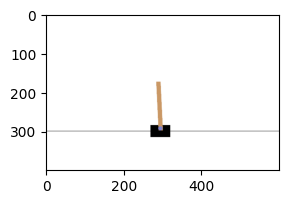

In [17]:
#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        over = terminated or truncated

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True
        
        #没坚持到最后,扣分
        if over and self.step_n < 200:
            reward = -1000

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [18]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(4, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 2),
            torch.nn.Softmax(dim=1),
        )
            
    def forward(self, state):
        return self.fc(state)

model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
print(model)

Model(
  (fc): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
    (5): Softmax(dim=1)
  )
)


In [20]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    state = []
    action = []
    reward = []

    s = env.reset()
    o = False
    while not o:
        #根据概率采样
        prob = model(torch.FloatTensor(s).reshape(1, 4).to(device))[0].tolist()
        a = random.choices(range(2), weights=prob, k=1)[0]

        ns, r, o = env.step(a)

        state.append(s)
        action.append(a)
        reward.append(r)

        s = ns

        if show:
            display.clear_output(wait=True)
            env.show()

    state = torch.FloatTensor(state).reshape(-1, 4).to(device)
    action = torch.LongTensor(action).reshape(-1, 1).to(device)
    reward = torch.FloatTensor(reward).reshape(-1, 1).to(device)

    return state, action, reward, reward.sum().item()


state, action, reward, reward_sum = play()

In [22]:
#训练
def train():
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

    #训练N局
    for epoch in range(1000):


        #玩一局游戏,得到数据
        state, action, reward, _ = play()

        #计算当前state的价值,其实就是Q(state,action),这里是用蒙特卡洛法估计的
        value = []
        for i in range(len(reward)):
            s = 0
            for j in range(i, len(reward)):
                s += reward[j] * 0.99**(j - i)
            value.append(s)
        value = torch.FloatTensor(value).reshape(-1, 1).to(device)

        #重新计算动作的概率
        prob = model(state).gather(dim=1, index=action)

        #求Q最大的导函数 -> partial value / partial action
        prob = (prob + 1e-8).log() * value
        for i in range(len(prob)):
            prob[i] = prob[i] * 0.99**i
        loss = -prob.mean()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if epoch % 100 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, loss.item(), test_result)


train()

0 -621.2605590820312 -982.45
100 -391.9500732421875 -950.9
200 -195.89453125 -933.0
300 -96.36827087402344 -384.1
400 13.46978759765625 148.1
500 14.104154586791992 200.0
600 14.29156494140625 200.0
700 15.018367767333984 200.0
800 16.969707489013672 200.0
900 15.589151382446289 200.0


In [1]:
play(True)[-1]

NameError: name 'play' is not defined